In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.stats as sp

/home/paval/papers/frontiers23/conda_env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
Country_code = 'UA'
data_path = '../data/'
path = "../AlgorithmABC/out/new_model/"

dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])
date_i, date_f = mobility.iloc[[0,-1]]['date']

values = pd.read_csv(path + f"values_{Country_code}.txt")
results = pd.read_csv(path + f"results_{Country_code}.txt")
dead = pd.read_csv(path + f"dead_{Country_code}.txt")

ndays = (pd.to_datetime(date_f) - pd.to_datetime(date_i)).days + 1
date_i, date_f

('2020-02-01', '2020-05-20')

In [3]:
country_list = ["AR", "AT", "BD", "BE", "BO", "BG", "CA", "CL", "CO", "EG", "FR", "GR", "DE", "GT",
                "HN", "HU", "ID", "IQ", "IE", "IL", "IT", "KW", "LU", "MY", "MX", "MA", "NG", "PK",
                "PA", "PH", "PL", "PT", "RO", "RU", "SA", "ZA", "ES", "CH", "TR", "US", "GB", "UA"]


priori = {
        'permeability':[0,1],
        'beta':[0.01, 0.30],
        # 'IFR':[0.002, 0.024],
        'xi':[1/18, 1/6],
        'init_days':[0,100],
        'delay':[2,20]}
params = list(priori.keys())
max_delay = priori['delay'][1]

In [4]:
def create_fatalities_lists(results):
    D = pd.Series(index=results['iter'].drop_duplicates(), dtype=object)
    for i in results['iter'].drop_duplicates():
        D.iloc[i] = pd.Series(results['D_sim'][i*ndays:i*ndays+ndays])
    return D

39.76025313428571


Text(0, 0.5, 'Mobility')

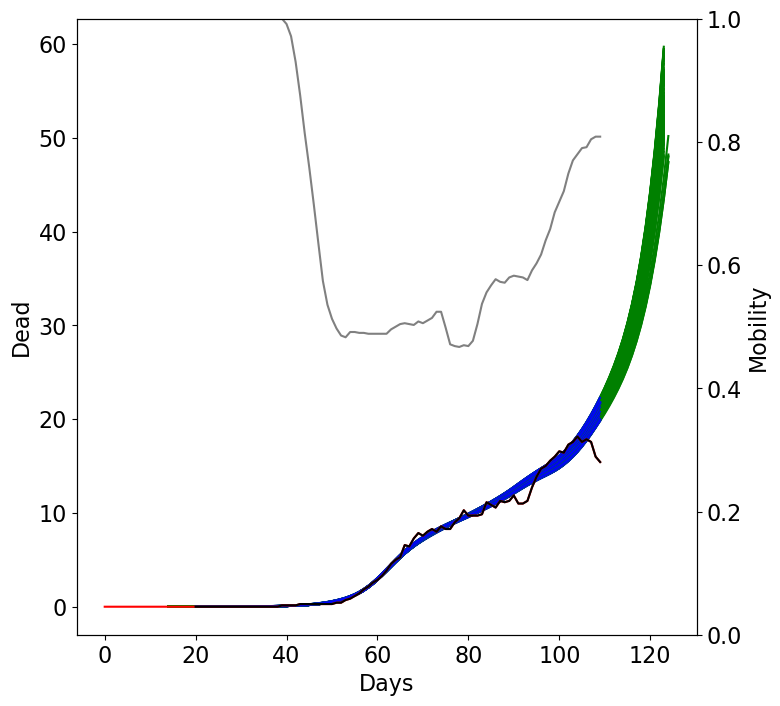

In [5]:
D = create_fatalities_lists(results).iloc[0:100]

fig,ax=plt.subplots(figsize=(8,8))
ax2 = ax.twinx()

for i,trajectory in enumerate(D):
    ax.plot(np.arange(int(values.iloc[i]['delay']), ndays + int(values.iloc[i]['delay'])),trajectory[:], c='green')
    ax.plot(np.arange(max_delay, ndays),trajectory[max_delay - int(values.iloc[i]['delay']):ndays - int(values.iloc[i]['delay'])], c='blue')

ax.plot(dead_obs.iloc[:]['dead'], c='red')
ax.plot(dead_obs.iloc[max_delay:]['dead'], c='black')

diff = (dead_obs.iloc[max_delay:]['dead'].values - D.iloc[0][max_delay - int(values.iloc[0]['delay']): ndays - int(values.iloc[0]['delay'])])
print(np.absolute(diff).sum())

ax2.plot(mobility['mobility'].values, c='grey')
ax2.set_ylim(0,1)

ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.set_xlabel('Days', fontsize=16)
ax.set_ylabel('Dead', fontsize=16)
ax2.set_ylabel('Mobility', fontsize=16)

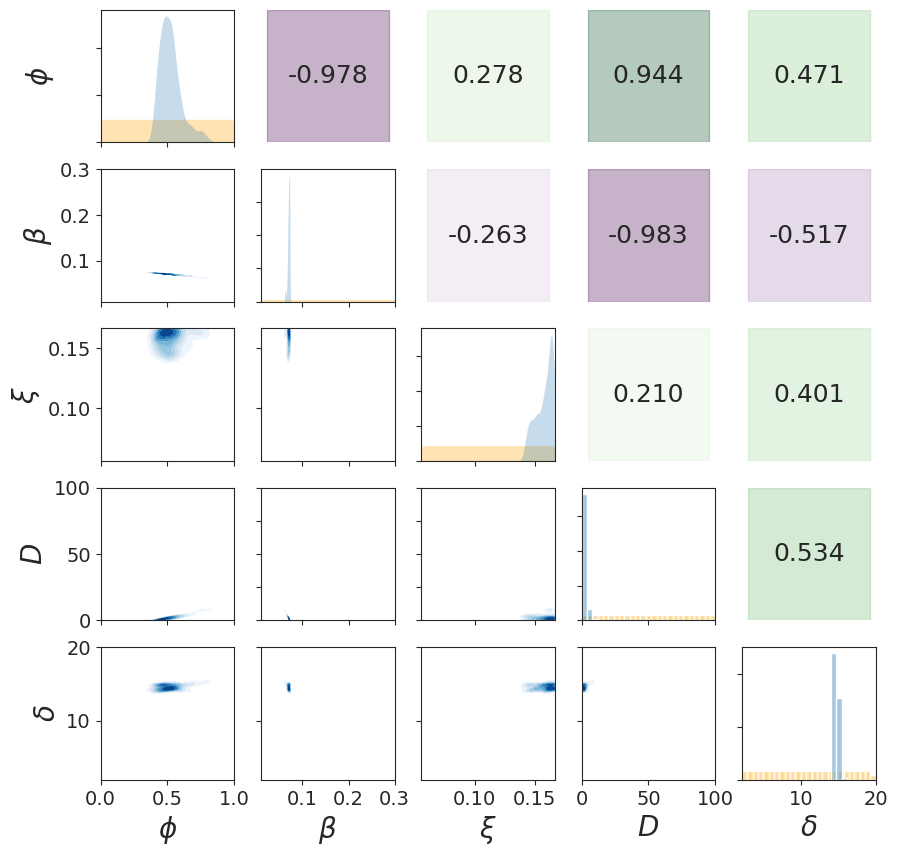

In [9]:
sns.set_style('ticks')
fig,axes=plt.subplots(len(params),len(params),figsize=(10,10))
n_values = 100
variable_symbols = {'beta':r'$\beta$', 'permeability':r'$\phi$', 'IFR':r'$IFR$', 'xi':r'$\xi$', 'init_days':r'$D$', 'delay':r'$\delta$'}
for i,value1 in enumerate(params):
    for j,value2 in enumerate(params):
        ax = axes[i,j]
        if i==j:
            
            if (value1 == 'init_days') | (value1 == 'delay'):
                sns.histplot(x=np.linspace(priori[value1][0],priori[value1][1]), ax=ax, linewidth=1, fill=True, color='orange', binwidth=(priori[value2][1] - priori[value2][0])/25, alpha=0.4, stat='probability')
                sns.histplot(data=values.iloc[:n_values], x=value2, fill=True, linewidth=1, ax=ax, stat='probability', binwidth=(priori[value2][1] - priori[value2][0])/25, alpha=0.4)
            else:
                sns.kdeplot(x=np.linspace(priori[value1][0],priori[value1][1]), ax=ax, bw_adjust=0.1, color='orange', fill=True, alpha=0.3, linewidth=0)
                sns.kdeplot(data=values.iloc[:n_values], x=value2, fill=True, linewidth=0, ax=ax, bw_adjust=0.8)


        elif i > j:
            sns.kdeplot(data = values.iloc[:n_values], x=value2, y=value1, cmap='Blues', fill=True, ax=ax, bw_adjust=1);

        else:
            correlation = (values[[value1,value2]].corr(method='spearman').iloc[0,1])
            ax.text(s= f'{correlation:2.3f}', x = 0.5, y = 0.5, ha='center', va='center', size=18)
            ax.axvspan(0,1, color=mpl.cm.PRGn(correlation/2+0.5), alpha=0.3)
            ax.axis('off')
        
        if (i==j) & (i==0):
            ax.set_yticklabels([])
            ax.set_ylabel(variable_symbols[value1], labelpad=25)
        
        if i>=j:
            ax.set_xlim(priori[value2][0],priori[value2][1])

        if i>j:
            ax.set_ylim(priori[value1][0],priori[value1][1])

        if i!=len(params)-1:
            ax.set_xticklabels([])
            ax.set_xlabel('')
        else:
            ax.set_xlabel(variable_symbols[value2])
            ax.xaxis.label.set_size(20)
            ax.tick_params(labelsize=14)


        if j!=0:
            ax.set_yticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel(variable_symbols[value1])
            ax.yaxis.label.set_size(20)
            ax.tick_params(labelsize=14)

#fig.savefig('figures/correlations/' + Country_code + '.pdf', dpi=300, bbox_inches='tight')

SpearmanrResult(correlation=-0.5592885375494071, pvalue=0.005526975377654656)

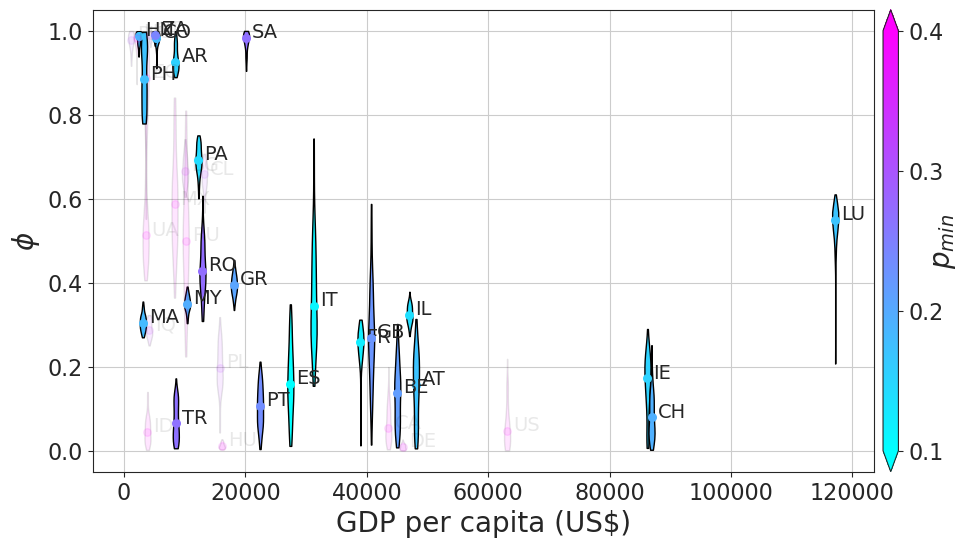

In [10]:
GDPpC = pd.read_csv(data_path + 'GDPPerCapita.csv', index_col='Country_code')
country_permeabilities = dict()
colormap = mpl.cm.cool
variable = 'permeability'

fig,ax = plt.subplots(figsize=(12,6))
country_values = pd.DataFrame(index=country_list, columns=['max_dead', 'badness', 'median', 'PIBPC', 'deathspc'])
country_populations = pd.read_csv(data_path + 'countries_population.txt', index_col=0)

for i,Country_code in enumerate(country_list):

    dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
    mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])

    date_i, date_f = mobility.iloc[[0,-1]]['date']
    try:
        values = pd.read_csv(path + f"values_{Country_code}.txt")
        results = pd.read_csv(path + f"results_{Country_code}.txt")
    except:
        continue

    D = create_fatalities_lists(results).iloc[0:1]

    diff = (dead_obs.iloc[max_delay:]['dead'].values - D.iloc[0][max_delay - int(values.iloc[0]['delay']): ndays - int(values.iloc[0]['delay'])])

    sum_dead = dead_obs['dead'].sum()
    badness = np.abs(diff).sum()/sum_dead


    inds = [GDPpC['GDP Per Capita'].loc[Country_code]]
    deaths_per_capita = dead_obs['dead'].sum() / country_populations['pop2020'].loc[Country_code]

    if((badness > 0.4) or (deaths_per_capita < 1e-010)):
        continue

    mobility_min, mobility_max = 0.1,0.4 # 0.082,0.55
    if (mobility['mobility'].min() < mobility_min):
        color = colormap(0)
    elif (mobility['mobility'].min() > mobility_max):
        color = colormap(1.01)
    else:
        color = colormap((mobility['mobility'].min() - mobility_min) / (mobility_max - mobility_min))

    if (mobility['mobility'].min() < 1000 * 0.3):
        alpha = 1
        #save the values for the regression
        country_values.loc[Country_code] = {'max_dead':sum_dead, 'badness':badness, 'median':values[variable].iloc[:n_values].median(), 'PIBPC':inds[0], 'deathspc':deaths_per_capita}
        country_permeabilities[Country_code] = values.iloc[:100][variable].to_numpy()
    else:
        alpha = 0.1


    parts = ax.violinplot(
        dataset = values[variable].iloc[:n_values], positions= inds, widths = 1000,# 0.00001, 
        showmeans=False, showmedians=False, showextrema=False, points=20)
    for pc in parts['bodies']:
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)
    
    quartile1, medians, quartile3 = np.percentile(values[variable].iloc[:n_values], [25, 50, 75], axis=0)
    pc.set_facecolor(color)
    ax.scatter(inds, medians, marker='o', color=color, s=30, zorder=3, alpha = alpha)

    
    ax.text(inds[0]+1000, medians, s=Country_code, fontsize=14, alpha=alpha)

country_values = country_values[['median', 'PIBPC', 'deathspc']].astype(float).dropna()

ax.set_ylim(-0.05,1.05)
# ax.set_xlim(1000,100000)

ax.set_xlabel('GDP per capita (US$)', fontsize=20)
ax.set_ylabel(r'$\phi$', fontsize=20)
ax.tick_params(labelsize=16)

try: #execute the next block of code to calculate the regression lines
    ax.plot(GDP_linear,regression_median, color='black', lw=3)
    ax.plot(GDP_linear,regression_975, color='black', lw=1, ls='--')
    ax.plot(GDP_linear,regression_025, color='black', lw=1, ls='--')
    ax.fill_between(GDP_linear, regression_025.astype(float), regression_975.astype(float), color='black', alpha=0.1)
except:
    pass

norm = plt.Normalize(vmin=0.1,vmax=0.4)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax, ticks=[0.1,0.2,0.3,0.4], extend='both', pad=0.01, aspect=30)
cbar.ax.set_yticklabels(['0.1','0.2','0.3','0.4'], fontsize=16)
cbar.set_label(r'$p_{min}$', fontsize=20, labelpad=-10)


ax.grid()


# fig.savefig('figures/permeability_0,4.pdf', dpi=300, bbox_inches='tight')
sp.spearmanr(country_values['PIBPC'], country_values['median'])

In [19]:
def potential_function(x,a,b):
    return (a / (x**b))

data = country_values[['median', 'PIBPC']].astype(float).dropna()

fits = np.empty((0,2))
for t in range(1000):
    perms = pd.DataFrame(columns=['PIBPC', 'perm'])
    for i,Country_code in enumerate(list(country_permeabilities.keys())):
        perms.loc[Country_code] = [GDPpC.loc[Country_code]['GDP Per Capita'], np.random.choice(country_permeabilities[Country_code])]

    popt, pcov = curve_fit(potential_function, perms['PIBPC'], perms['perm'], p0 = [70, 0.6])

    fits = np.insert(fits, t, popt, axis=0)

GDP_linear = country_values['PIBPC'].sort_values()
GDP_linear = np.linspace(500,120000,1000)

regression_median = pd.Series(index=GDP_linear, dtype=float)
regression_975 = pd.Series(index=GDP_linear, dtype=object)
regression_025 = pd.Series(index=GDP_linear, dtype=object)

for x in GDP_linear:
    regression_median[x] = np.median([potential_function(x,fits[i,0],fits[i,1]) for i in range(len(fits))])
    regression_975[x] = np.quantile([potential_function(x,fits[i,0],fits[i,1]) for i in range(len(fits))], [0.975])
    regression_025[x] = np.quantile([potential_function(x,fits[i,0],fits[i,1]) for i in range(len(fits))], [0.025])

KeyboardInterrupt: 

In [9]:
np.quantile(fits, axis=0, q=[0.025, 0.5, 0.975])
np.std(fits, axis=0)

#for pmin = 0.4
#141.07691512,   0.70026015
# [5.62239006e+01, 4.87544945e-02]

NameError: name 'fits' is not defined

Text(0, 0.5, '$\\varepsilon^{min}$')

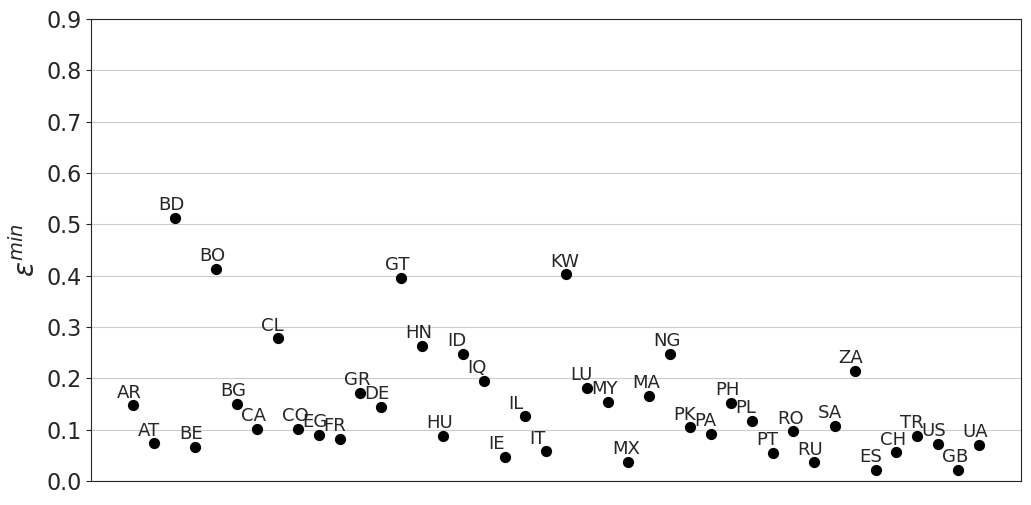

In [11]:
GDPpC = pd.read_csv(data_path + 'GDPPerCapita.csv', index_col='Country_code')

sns.set_style('ticks')

fig,ax = plt.subplots(figsize=(12,6))
# for i,Country_code in enumerate(['ES', 'IT', 'CO', 'FR', 'US', 'UK']):

pd_mins = pd.Series(index=country_list, dtype=float)

for i,Country_code in enumerate(country_list):

    dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
    mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])
    date_i, date_f = mobility.iloc[[0,-1]]['date']

    try:
        values = pd.read_csv(path + f"values_{Country_code}.txt")
        results = pd.read_csv(path + f"results_{Country_code}.txt")
    except:
        continue

    D = create_fatalities_lists(results).iloc[0:1]
    
    diff = (dead_obs.iloc[max_delay:]['dead'].values - D.iloc[0][max_delay - int(values.iloc[0]['delay']): ndays - int(values.iloc[0]['delay'])])
    sum_dead = dead_obs['dead'].sum()
    badness = (np.abs(diff).sum())/sum_dead

    ax.scatter(i, badness, color='k', s=50)
    ax.text(i-0.8, badness + 0.015, s=Country_code, fontsize=13)
    ax.set_ylim(0,0.9)
    # ax.set_xlim(0,9)
    pd_mins.loc[Country_code] = mobility['mobility'].min()

ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.grid(axis='y')
ax.set_ylabel(r'$\varepsilon^{min}$', fontsize=20)

#fig.savefig('figures/error.pdf', dpi=300, bbox_inches='tight')

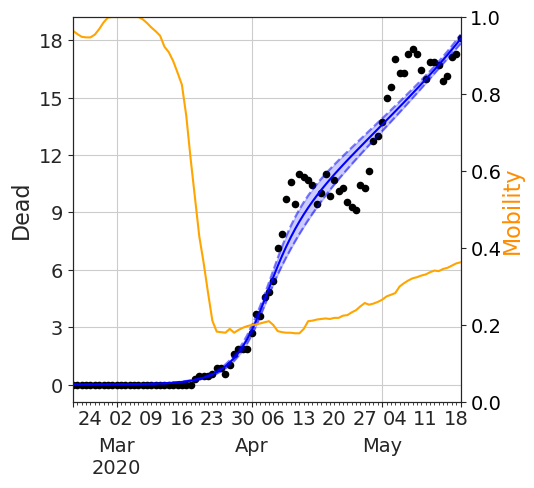

In [13]:
sns.set_style("ticks")

Country_code = 'CO'

dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])

date_i, date_f = mobility.iloc[[0,-1]]['date']
ndays = (pd.to_datetime(date_f) - pd.to_datetime(date_i)).days + 1
date_i, date_f

values = pd.read_csv(path + f"values_{Country_code}.txt")
results = pd.read_csv(path + f"results_{Country_code}.txt")
dead = pd.read_csv(path + f"dead_{Country_code}.txt")

D = create_fatalities_lists(results).iloc[0:200]

fig,ax=plt.subplots(figsize=(5,5))
ax2 = ax.twinx()

#average all the trajectories
D_avg = pd.Series(index=np.arange(ndays-max_delay), dtype=object)
D_std = pd.Series(index=np.arange(ndays-max_delay), dtype=object)
for i in range(ndays-max_delay):
    
    cut_trajectory = [trajectory[max_delay - int(values.iloc[j]['delay']):ndays - int(values.iloc[j]['delay'])][i] for j,trajectory in enumerate(D)]
    
    D_avg.iloc[i] = np.mean(cut_trajectory)
    D_std.iloc[i] = np.std(cut_trajectory) * 1.96
#plot the average trajectory

#series of dates from 02-02-2020 to 02-05-2020
dates1 = pd.date_range('2020-02-20', periods=ndays-max_delay, freq='D')

D_avg.index=dates1
D_std.index=dates1
D_avg.plot(ax=ax, c='blue')
(D_avg+D_std).plot(ax=ax, c='blue', linestyle='--', alpha=0.5)
(D_avg-D_std).plot(ax=ax, c='blue', linestyle='--', alpha=0.5)
ax.fill_between(dates1, (D_avg + D_std).astype(float).values, (D_avg - D_std).astype(float).values, color='blue', alpha=0.2)

ax.scatter(dates1,dead_obs.iloc[max_delay:]['dead'], c='black', s=20)

dates2 = pd.date_range('2020-02-01', periods=ndays, freq='D')
ax2.plot(dates2, mobility['mobility'].values, c='orange')
ax2.set_ylim(0,1)

ax.tick_params(labelsize=14)
ax.tick_params(axis='x', which='minor', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=14, pad=-10)
ax.tick_params(axis='y',labelsize=14)
#make yaxis integer numbers
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

ax2.tick_params(axis='y',labelsize=14, labelcolor='k')

ax.set_ylabel('Dead', fontsize=16)
ax2.set_ylabel('Mobility', fontsize=16, color='darkorange', labelpad=0)


ax.grid()
#fig.savefig('figures/fits/' + Country_code + '.png', dpi=300, bbox_inches='tight')

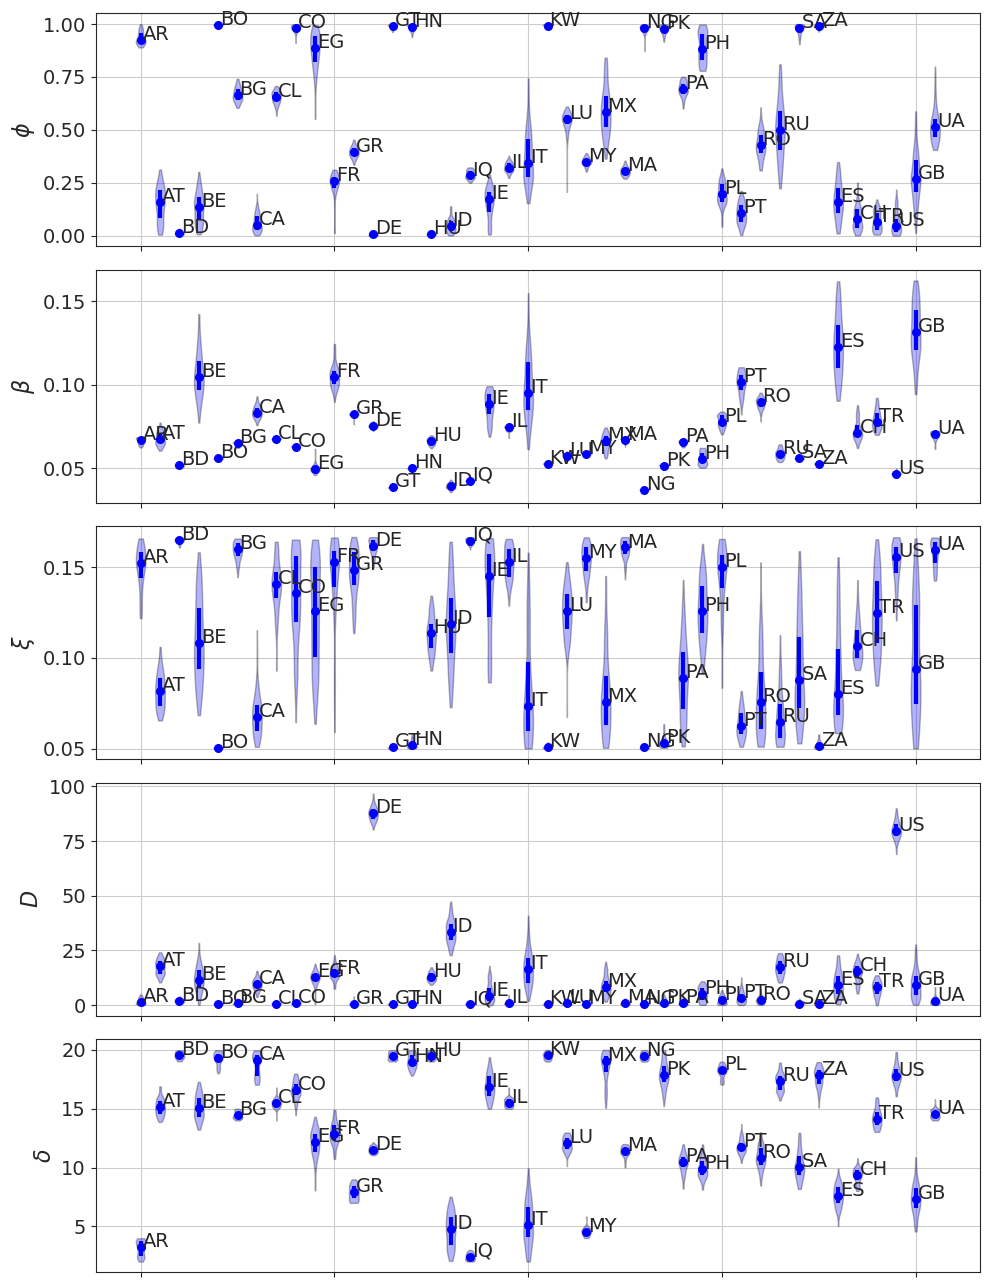

In [14]:
GDPpC = pd.read_csv(data_path + 'GDPPerCapita.csv', index_col='Country_code')
labels = ['a)','b)','c)','d)','e)']
variable_symbols = {'beta':r'$\beta$', 'permeability':r'$\phi$', 'IFR':r'$IFR$', 'xi':r'$\xi$', 'init_days':r'$D$', 'delay':r'$\delta$'}
fig,axes = plt.subplots(len(params),1,figsize=(10,13))

country_values = pd.DataFrame(index=country_list, columns=['max_dead', 'badness', 'median', 'PIBPC'])
for j,variable in enumerate(params):
    ax = axes[j]
    for i,Country_code in enumerate(country_list):

        dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
        mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])
        date_i, date_f = mobility.iloc[[0,-1]]['date']
        try:
            values = pd.read_csv(path + f"values_{Country_code}.txt")
            results = pd.read_csv(path + f"results_{Country_code}.txt")
        except:
            continue

        D = create_fatalities_lists(results).iloc[0:1]

        diff = (dead_obs.iloc[max_delay:]['dead'].values - D.iloc[0][max_delay - int(values.iloc[0]['delay']): ndays - int(values.iloc[0]['delay'])])

        sum_dead = dead_obs['dead'].sum()
        badness = np.abs(diff).sum()/sum_dead

        inds = [i] #[GDPpC['GDP Per Capita'].loc[Country_code]]

        parts = ax.violinplot(
            dataset = values[variable].iloc[:n_values], positions= inds, widths = 0.5, 
            showmeans=False, showmedians=False, showextrema=False, points=20)
        for pc in parts['bodies']:
                pc.set_edgecolor('black')
                pc.set_alpha(0.3)
        
        quartile1, medians, quartile3 = np.percentile(values[variable].iloc[:n_values], [25, 50, 75], axis=0)

        pc.set_facecolor('blue')
        ax.vlines(inds, quartile1, quartile3, color='blue', linestyle='-', lw=3)
        ax.scatter(inds, medians, marker='o', color='blue', s=30, zorder=3)

        ax.text(inds[0]+0.1, medians, s=Country_code, fontsize=14)

    ax.set_xticklabels([])
    ax.set_ylabel(variable_symbols[variable], fontsize=16)
    ax.tick_params(labelsize=14)
    ax.grid()

fig.tight_layout(h_pad=1, w_pad=0.4)
# fig.savefig('figures/params_countries.pdf', dpi=300, bbox_inches='tight')

In [14]:
fig.savefig('figures/params_countries.JPEG', dpi=300, bbox_inches='tight')


In [15]:
group_1 = ['BO', 'KW', 'BD', 'ZA', 'HN', 'AR', 'PH', 'CO', 'PA', 'SA']
group_2 = ['IT', 'ES', 'FR', 'IL', 'IE', 'LU', 'AT', 'GB', 'PT', 'CH', 'MA', 'MY', 'GR', 'BE', 'RO', 'TR']
group_3 = ['US','DE']
group_3 = [country for country in country_list if country not in group_1 + group_2]

/var/folders/68/y4rdzskn3911g1y9ls2qn0ch0000gq/T/ipykernel_1092/3383466542.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["{i:.0f}".format(i=i*100000) for i in ax.get_xticks()])


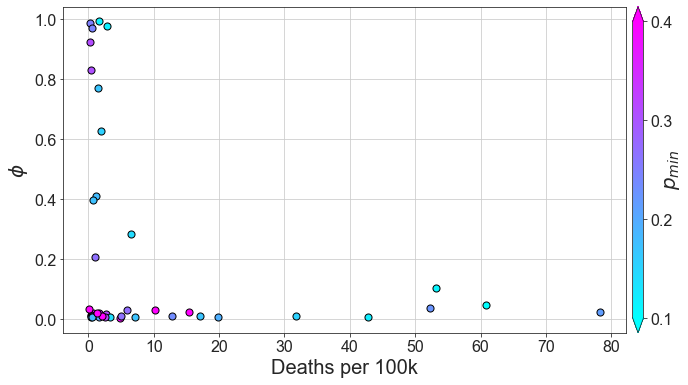

In [41]:
GDPpC = pd.read_csv(data_path + 'GDPPerCapita.csv', index_col='Country_code')
country_permeabilities = dict()
colormap = mpl.cm.cool
variable = 'beta'

fig,ax = plt.subplots(figsize=(12,6))
country_values = pd.DataFrame(index=country_list, columns=['max_dead', 'badness', 'median', 'PIBPC', 'deathspc'])
country_populations = pd.read_csv(data_path + 'countries_population.txt', index_col=0)

for i,Country_code in enumerate(country_list):

    dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
    mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])
    date_i, date_f = mobility.iloc[[0,-1]]['date']
    values = pd.read_csv(path + f"values_{Country_code}.txt")
    results = pd.read_csv(path + f"results_{Country_code}.txt")
    D = create_fatalities_lists(results).iloc[0:1]

    diff = (dead_obs.iloc[max_delay:]['dead'].values - D.iloc[0][max_delay - int(values.iloc[0]['delay']): ndays - int(values.iloc[0]['delay'])])

    sum_dead = dead_obs['dead'].sum()
    badness = np.abs(diff).sum()/sum_dead


    inds = [GDPpC['GDP Per Capita'].loc[Country_code]]
    deaths_per_capita = dead_obs['dead'].sum() / country_populations['pop2020'].loc[Country_code]

    if((badness > 0.4) or (deaths_per_capita < 1e-010)):
        continue
    
    median_beta = np.percentile(values['beta'].iloc[:n_values], [25, 50, 75], axis=0)
    median_permeability = np.percentile(values['permeability'].iloc[:n_values], 50, axis=0)

    mobility_min, mobility_max = 0.1,0.4 # 0.082,0.55
    if (mobility['mobility'].min() < mobility_min):
        color = colormap(0)
    elif (mobility['mobility'].min() > mobility_max):
        color = colormap(1.01)
    else:
        color = colormap((mobility['mobility'].min() - mobility_min) / (mobility_max - mobility_min))
    # if(Country_code in group_1):
    #     color = 'red'
    # elif(Country_code in group_2):
    #     color = 'blue'
    # else:
    #     color = 'green'
    # color = 'black'
    ax.scatter(deaths_per_capita, median_permeability, marker='o', color=color, s=50, zorder=3, alpha = 1, edgecolors='black')
        
    
    # ax.text(inds[0]+1000, medians, s=Country_code, fontsize=14, alpha=1)

country_values = country_values[['median', 'PIBPC', 'deathspc']].astype(float).dropna()

# ax.set_ylim(-0.05,1.05)
# ax.set_xlim(1000,100000)

ax.set_xlabel(r'Deaths per 100k', fontsize=20)
ax.set_ylabel(r'$\phi$', fontsize=20)
ax.tick_params(labelsize=16)

ax.set_xticklabels(["{i:.0f}".format(i=i*100000) for i in ax.get_xticks()])

ax.grid()

norm = plt.Normalize(vmin=0.1,vmax=0.4)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax, ticks=[0.1,0.2,0.3,0.4], extend='both', pad=0.01, aspect=30)
cbar.ax.set_yticklabels(['0.1','0.2','0.3','0.4'], fontsize=16)
cbar.set_label(r'$p_{min}$', fontsize=20, labelpad=-10)

#fig.savefig('figures/permeability_deaths.pdf', dpi=200, bbox_inches='tight')

/var/folders/68/y4rdzskn3911g1y9ls2qn0ch0000gq/T/ipykernel_1092/487552337.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["{i:.0f}%".format(i=100*i) for i in ax.get_xticks()])


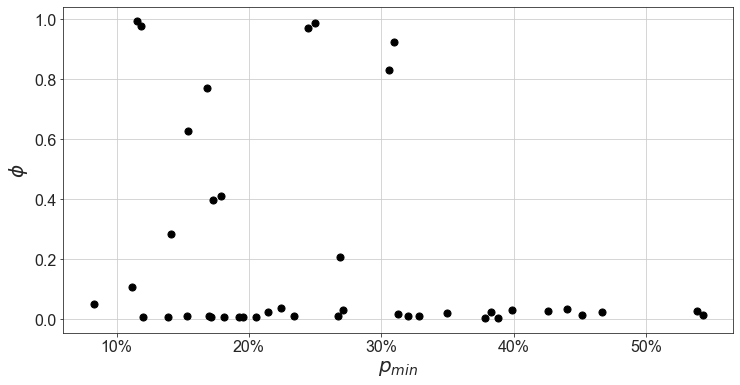

In [21]:
GDPpC = pd.read_csv(data_path + 'GDPPerCapita.csv', index_col='Country_code')
country_permeabilities = dict()

colormap = mpl.cm.inferno
variable = 'beta'
fig,ax = plt.subplots(figsize=(12,6))
country_values = pd.DataFrame(index=country_list, columns=['max_dead', 'badness', 'median', 'PIBPC', 'deathspc'])
country_populations = pd.read_csv(data_path + 'countries_population.txt', index_col=0)

for i,Country_code in enumerate(country_list):

    dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
    mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])
    date_i, date_f = mobility.iloc[[0,-1]]['date']
    values = pd.read_csv(path + f"values_{Country_code}.txt")
    results = pd.read_csv(path + f"results_{Country_code}.txt")
    D = create_fatalities_lists(results).iloc[0:1]

    diff = (dead_obs.iloc[max_delay:]['dead'].values - D.iloc[0][max_delay - int(values.iloc[0]['delay']): ndays - int(values.iloc[0]['delay'])])

    sum_dead = dead_obs['dead'].sum()
    badness = np.abs(diff).sum()/sum_dead


    inds = [mobility['mobility'].min()]
    deaths_per_capita = dead_obs['dead'].sum() / country_populations['pop2020'].loc[Country_code]

    # if((badness > 0.4) or (deaths_per_capita < 1e-010)):
    #     continue
    
    median_beta = np.percentile(values['beta'].iloc[:n_values], [25, 50, 75], axis=0)
    median_permeability = np.percentile(values['permeability'].iloc[:n_values], 50, axis=0)

    mobility_min, mobility_max = 0.1,0.4 # 0.082,0.55
    
    # color = colormap(GDPpC['GDP Per Capita'].loc[Country_code] / 100000)
    if(Country_code in group_1):
        color = 'red'
    elif(Country_code in group_2):
        color = 'blue'
    else:
        color = 'green'
    color = 'black'
    
    ax.scatter(mobility['mobility'].min(), median_permeability, marker='o', color=color, s=50, zorder=3, alpha = 1, edgecolors='black')
    # ax.text(mobility['mobility'].min() + 0.02, median_permeability + 0.01, s=Country_code, fontsize=14, alpha=1, ha='center', va='center')

    # ax.text(inds[0]+1000, medians, s=Country_code, fontsize=14, alpha=1)

country_values = country_values[['median', 'PIBPC', 'deathspc']].astype(float).dropna()

# ax.set_ylim(-0.05,1.05)
# ax.set_xlim(1000,100000)

ax.set_xlabel(r'$p_{min}$', fontsize=20)
ax.set_ylabel(r'$\phi$', fontsize=20)
ax.tick_params(labelsize=16)

ax.set_xticklabels(["{i:.0f}%".format(i=100*i) for i in ax.get_xticks()])

ax.grid()

#fig.savefig('figures/permeability_pmin.pdf', dpi=200, bbox_inches='tight')

/var/folders/68/y4rdzskn3911g1y9ls2qn0ch0000gq/T/ipykernel_1092/1256211223.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["{i:.0f}".format(i=i*100000) for i in ax.get_xticks()])


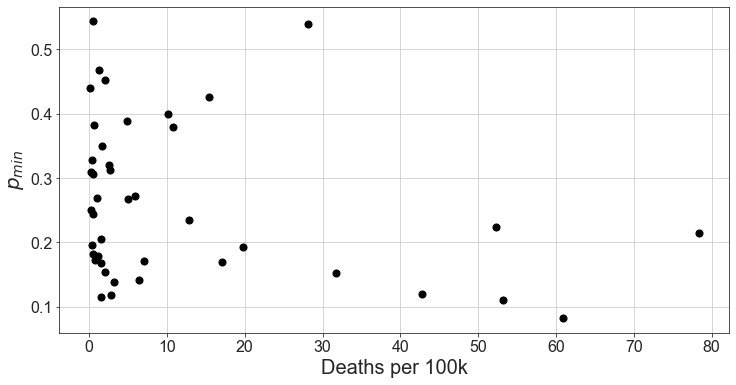

In [22]:
GDPpC = pd.read_csv(data_path + 'GDPPerCapita.csv', index_col='Country_code')
country_permeabilities = dict()
colormap = mpl.cm.cool
variable = 'beta'

fig,ax = plt.subplots(figsize=(12,6))
country_values = pd.DataFrame(index=country_list, columns=['max_dead', 'badness', 'median', 'PIBPC', 'deathspc'])
country_populations = pd.read_csv(data_path + 'countries_population.txt', index_col=0)

for i,Country_code in enumerate(country_list):

    dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
    mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])
    date_i, date_f = mobility.iloc[[0,-1]]['date']
    values = pd.read_csv(path + f"values_{Country_code}.txt")
    results = pd.read_csv(path + f"results_{Country_code}.txt")
    D = create_fatalities_lists(results).iloc[0:1]

    diff = (dead_obs.iloc[max_delay:]['dead'].values - D.iloc[0][max_delay - int(values.iloc[0]['delay']): ndays - int(values.iloc[0]['delay'])])

    sum_dead = dead_obs['dead'].sum()
    badness = np.abs(diff).sum()/sum_dead


    inds = [GDPpC['GDP Per Capita'].loc[Country_code]]
    deaths_per_capita = dead_obs['dead'].sum() / country_populations['pop2020'].loc[Country_code]

    # if((badness > 0.4) or (deaths_per_capita < 1e-010)):
    #     continue
    
    median_beta = np.percentile(values['beta'].iloc[:n_values], [25, 50, 75], axis=0)
    median_permeability = np.percentile(values['permeability'].iloc[:n_values], 50, axis=0)

    if(Country_code in group_1):
        color = 'red'
    elif(Country_code in group_2):
        color = 'blue'
    else:
        color = 'green'
    color = 'black'
    
    ax.scatter(deaths_per_capita, mobility['mobility'].min(), marker='o', color=color, s=50, zorder=3, alpha = 1, edgecolors='black')
        
    
    # ax.text(inds[0]+1000, medians, s=Country_code, fontsize=14, alpha=1)

country_values = country_values[['median', 'PIBPC', 'deathspc']].astype(float).dropna()

# ax.set_ylim(-0.05,1.05)
# ax.set_xlim(1000,100000)

ax.set_xlabel(r'Deaths per 100k', fontsize=20)
ax.set_ylabel(r'$p_{min}$', fontsize=20)
ax.tick_params(labelsize=16)

ax.set_xticklabels(["{i:.0f}".format(i=i*100000) for i in ax.get_xticks()])

ax.grid()

#fig.savefig('figures/p_min_deaths.pdf', dpi=200, bbox_inches='tight')

SpearmanrResult(correlation=-0.5035897435897435, pvalue=0.008722438866213064)

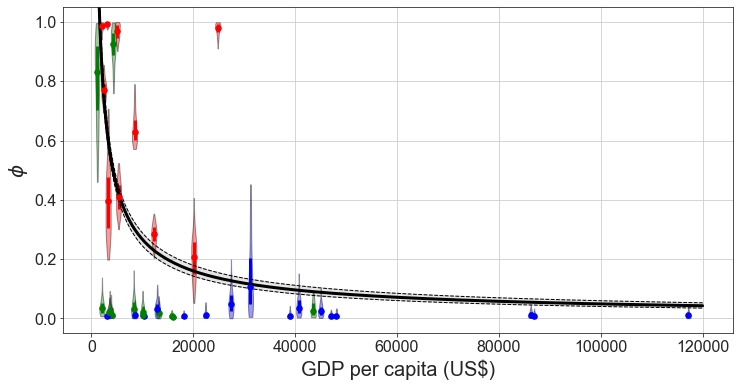

In [55]:
GDPpC = pd.read_csv(data_path + 'GDPPerCapita.csv', index_col='Country_code')
country_permeabilities = dict()
colormap = mpl.cm.cool
variable = 'permeability'

fig,ax = plt.subplots(figsize=(12,6))
country_values = pd.DataFrame(index=country_list, columns=['max_dead', 'badness', 'median', 'PIBPC', 'deathspc'])
country_populations = pd.read_csv(data_path + 'countries_population.txt', index_col=0)

for i,Country_code in enumerate(country_list):

    dead_obs = pd.read_csv(f'{data_path}dead/dead_{Country_code}.txt', sep='\t', header=None, names=['date', 'dead'])
    mobility = pd.read_csv(f'{data_path}mobility/mobility_{Country_code}.txt', sep='\t', header=None, names=['date', 'mobility'])

    date_i, date_f = mobility.iloc[[0,-1]]['date']
    try:
        values = pd.read_csv(path + f"values_{Country_code}.txt")
        results = pd.read_csv(path + f"results_{Country_code}.txt")
    except:
        continue

    D = create_fatalities_lists(results).iloc[0:1]

    diff = (dead_obs.iloc[max_delay:]['dead'].values - D.iloc[0][max_delay - int(values.iloc[0]['delay']): ndays - int(values.iloc[0]['delay'])])

    sum_dead = dead_obs['dead'].sum()
    badness = np.abs(diff).sum()/sum_dead


    inds = [GDPpC['GDP Per Capita'].loc[Country_code]]
    deaths_per_capita = dead_obs['dead'].sum() / country_populations['pop2020'].loc[Country_code]

    if((badness > 0.4) or (deaths_per_capita < 1e-010)):
        continue

    mobility_min, mobility_max = 0.1,0.4 # 0.082,0.55
    # if (mobility['mobility'].min() < mobility_min):
    #     color = colormap(0)
    # elif (mobility['mobility'].min() > mobility_max):
    #     color = colormap(1.01)
    # else:
    #     color = colormap((mobility['mobility'].min() - mobility_min) / (mobility_max - mobility_min))

    if(Country_code in group_1):
        color = 'red'
    elif(Country_code in group_2):
        color = 'blue'
    else:
        color = 'green'

    if (mobility['mobility'].min() < 0.3):
        alpha = 1
        #save the values for the regression
        country_values.loc[Country_code] = {'max_dead':sum_dead, 'badness':badness, 'median':values[variable].iloc[:n_values].median(), 'PIBPC':inds[0], 'deathspc':deaths_per_capita}
        country_permeabilities[Country_code] = values.iloc[:100][variable].to_numpy()
    else:
        alpha = 1


    parts = ax.violinplot(
        dataset = values[variable].iloc[:n_values], positions= inds, widths = 1000,# 0.00001, 
        showmeans=False, showmedians=False, showextrema=False, points=20)
    for pc in parts['bodies']:
            pc.set_edgecolor('black')
            pc.set_alpha(alpha * 0.4)
    
    quartile1, medians, quartile3 = np.percentile(values[variable].iloc[:n_values], [25, 50, 75], axis=0)
    pc.set_facecolor(color)
    ax.scatter(inds, medians, marker='o', color=color, s=30, zorder=3, alpha = alpha)
    ax.vlines(inds, quartile1, quartile3, color=color, linestyle='-', lw=3)
    
    # ax.text(inds[0]+1000, medians, s=Country_code, fontsize=14, alpha=alpha)

country_values = country_values[['median', 'PIBPC', 'deathspc']].astype(float).dropna()

ax.set_ylim(-0.05,1.05)
# ax.set_xlim(1000,100000)

ax.set_xlabel('GDP per capita (US$)', fontsize=20)
ax.set_ylabel(r'$\phi$', fontsize=20)
ax.tick_params(labelsize=16)

try: #execute the next block of code to calculate the regression lines
    ax.plot(GDP_linear,regression_median, color='black', lw=3)
    ax.plot(GDP_linear,regression_975, color='black', lw=1, ls='--')
    ax.plot(GDP_linear,regression_025, color='black', lw=1, ls='--')
    ax.fill_between(GDP_linear, regression_025.astype(float), regression_975.astype(float), color='black', alpha=0.1)
except:
    pass

ax.grid()


#fig.savefig('figures/permeability.png', dpi=300, bbox_inches='tight')
sp.spearmanr(country_values['PIBPC'], country_values['median'])